In [116]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from myrand import generate_exp, generate_TCL_ms

# Campione di 2000 eventi esponenziali (tau = 200) e 200 eventi gaussiani (mu = 190, sigma = 20) e uniscili

In [140]:
tau = 200
N = 2000
mean = 190
sigma = 20
n = 200

# genero i campioni 

sample_e = generate_exp(tau, N)
sample_g = generate_TCL_ms(mean, sigma, n)

#li unisco
sample_tot = sample_e + sample_g



# Rappresentali in un istogramma (compresi fra 0 e 3 tau)

In [141]:
from mix import sturges

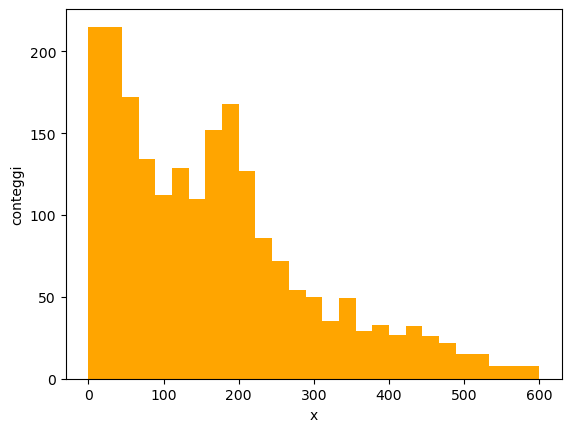

In [142]:
N_bins = sturges(len(sample_tot))
#uso np.histogram per generare entro un certo range
bin_content, bin_edges = np.histogram(sample_tot, bins = N_bins, range = (0, 3 * tau)) #delimito i dati
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(sample_tot, bins = bin_edges, color = 'orange')
ax.set_ylabel('conteggi');
ax.set_xlabel('x');

# EFFETTUA UN FIT DEL CAMPIONE (FIT BINNED)

In [143]:
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL
from scipy.stats import norm
from scipy.stats import expon

In [144]:
def mod_total (bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf(bin_edges, mu, sigma) + \
    N_background * expon.cdf (bin_edges, 0, tau)

    
my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, mod_total)

N_events = sum(bin_content)      
sample_mean = np.mean(sample_tot)  
sample_sigma = np.std(sample_tot) 

fit = Minuit(my_cost_func, N_signal = N_events, mu = sample_mean, sigma = sample_sigma, #parametri di signal
             N_background = N_events, tau = sample_mean) #parametri di background
fit.migrad()
fit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.94 (χ²/ndof = 1.2)      │              Nfcn = 756              │
│ EDM = 1.8e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │    222    │    31     │            │            │         │         │       │
│ 1 │ mu           │   190.1   │    3.4    │            │            │         │         │       │
│ 2 │ sigma        │    23     │     4     │            │            │         │         │       │
│ 3 │ N_background │  1.97e3   │  0.05e3   │            │            │         │         │       │
│ 4 │ tau          │    193    │     6     │            │            │         │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │          957            3           68       -0.8e3          -20 │
│           mu │            3         11.7            2           -6           -2 │
│        sigma │           68            2         15.3          -74           -2 │
│ N_background │       -0.8e3           -6          -74     3.01e+03           80 │
│          tau │          -20           -2           -2           80         38.4 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

# COSTRUIRE FUNZIONE CHE CALCOLI LOGLIKELIHOOD ASSOCIATA AL CAMPIONE, DATO UN MODELLO f(x) = a * exp(x,lambda) + b * gauss(x, mu, sigma) variando il valore di mu fra 30 e 300

In [145]:
#parametri del modello che rimangono fissati
tau = fit.values['tau']
lamb = 1/tau
sigma = fit.values['sigma']
gau_norm = 1 / (np.sqrt(2*np.pi)*sigma)  #fattore della gaussiana prima dell'esponenziale
n_exp = fit.values['N_background'] #numero di eventi associati a exp
n_gau = fit.values['N_signal'] #numero associati a gaussiana
n_tot = n_exp + n_gau
f_exp = n_exp / n_tot  #frazione degli eventi associati a exp
f_gau = n_gau / n_tot  #frazione degli eventi associati a gau

#costruisco la funzione con parametro mu
def pdf(x, mean):
    return f_exp * lamb * np.exp(-x*lamb) + \
    f_gau * gau_norm * np.exp(-0.5 * ((x-mean)/sigma)**2)

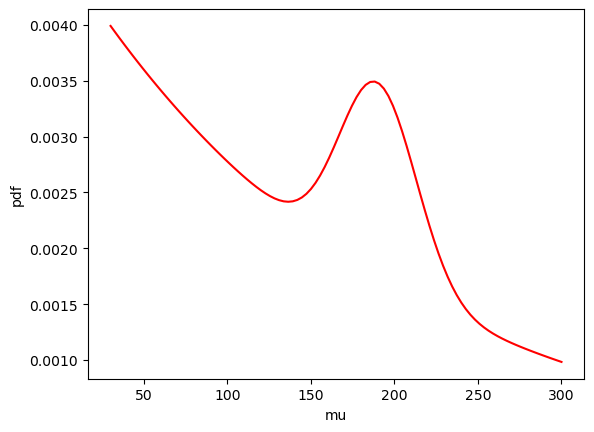

In [146]:
#disegno dell'andamento della pdf in funzione di mu

fig, ax = plt.subplots()
x_coord = np.linspace(30, 300, 100)
ax.plot(x_coord, pdf(x_coord, fit.values['mu']), color = 'red')
ax.set_xlabel('mu');
ax.set_ylabel('pdf');

# Disegno della loglikelihood

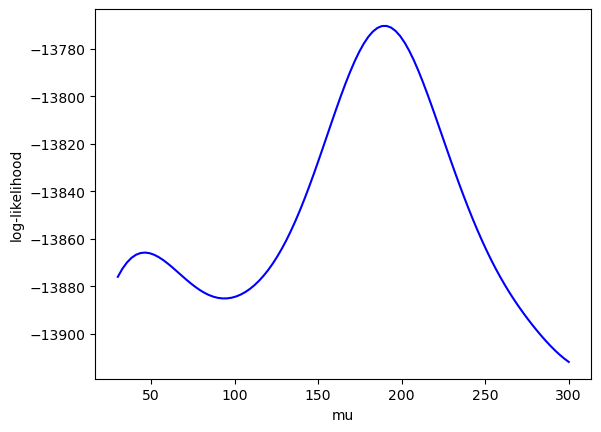

In [153]:
from likely import loglikelihood

fig, ax = plt.subplots()
l_like = []
for x in x_coord: l_like.append(loglikelihood(x, pdf, sample_tot))

ax.plot(x_coord, l_like, color = 'blue') 
ax.set_xlabel ('mu');
ax.set_ylabel ('log-likelihood');

# Determinazione del massimo tramite sezione aurea

In [160]:
def sezioneAureaMax (x0, x1, prec = 0.0001):
    r = 0.618
    x2 = 0.
    x3 = 0.
    
    while (abs (x1-x0)>prec): #x0, x3, x2, x1
        x2 = x0 + r * (x1 - x0)
        x3 = x0 + (1. - r) * (x1 - x0)
        if loglikelihood (x3, pdf, sample_tot) < loglikelihood (x2, pdf, sample_tot):
            x0 = x3
        else: x1 = x2
    return(x0 + x1) / 2

maxll = sezioneAureaMax(30, 300, 0.1)

print(f'il valore del parametro mu che massimizza la verosimiglianza è: {maxll:.2f}')

il valore del parametro mu che massimizza la verosimiglianza è: 189.73
